In [1]:
#setup
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_context("paper", font_scale=10)

# Data Cleaning: Primary Care Shortage Areas

In [2]:
#load primary care shortage areas csv
pcsa = pd.read_csv('https://data.chhs.ca.gov/dataset/061494a3-e8c7-4615-a22f-b2851d44eb09/resource/0ba7c904-2302-400a-ba27-b8e8e5c1ab4a/download/pcsa.csv')
#filter out the counties to only get counties in the central valley
pcsa_sub = pcsa.loc[(pcsa['MSSA_COUNTY'] == 'Butte') | (pcsa['MSSA_COUNTY'] == 'Glenn') | 
(pcsa['MSSA_COUNTY'] == 'Fresno') | (pcsa['MSSA_COUNTY'] == 'Kern') | 
(pcsa['MSSA_COUNTY'] == 'Kings') | (pcsa['MSSA_COUNTY'] == 'Madera') | 
(pcsa['MSSA_COUNTY'] == 'Merced') | (pcsa['MSSA_COUNTY'] == 'Placer') | 
(pcsa['MSSA_COUNTY'] == 'San Joaquin') | (pcsa['MSSA_COUNTY'] == 'Sacramento') | 
(pcsa['MSSA_COUNTY'] == 'Shasta') | (pcsa['MSSA_COUNTY'] == 'Solano') | 
(pcsa['MSSA_COUNTY'] == 'Stanislaus') | (pcsa['MSSA_COUNTY'] == 'Sutter') | 
(pcsa['MSSA_COUNTY'] == 'Tehama') | (pcsa['MSSA_COUNTY'] == 'Tulare')
]
# only keep columns for county, score provider ratio, poverty score, total score, PCSA & Population
pcsa_sub = pcsa_sub[['MSSA_COUNTY', 'Score_Provider_Ratio', 'Score_Poverty', 'Score_Total', 'PCSA', 'Total_Population']]

# rename county column
pcsa_sub.columns = ['County','Score_Provider_Ratio', 'Score_Poverty','Score_Total', 'PCSA', 'Population']

# replace Yes and No PCSA values with binary values
def replace_with_number(value):
   
    value = value.replace("No", 0)
    value = value.replace("Yes", 1)
    
    return value
pcsa_sub = pcsa_sub.apply(replace_with_number)

# get average score total and number of PCSA cities/areas within the county 
list_counties = pcsa_sub.County.unique()
pcsa_county = pd.DataFrame(
                   columns=['County', 'Score_Provider_Ratio', 'Score_Poverty', 'Score_Total', 'PCSAs_Total','Population'])
for county in list_counties:
    # add total provider ratio for each county
    provider_rate_total = pcsa_sub.loc[(pcsa_sub['County'] == county)]['Score_Provider_Ratio'].sum()
    # add total poverty score for each county
    poverty_score_total = pcsa_sub.loc[(pcsa_sub['County'] == county)]['Score_Poverty'].sum()
    # add total scores for each county
    ind_score_total = pcsa_sub.loc[(pcsa_sub['County'] == county)]['Score_Total'].sum()
    # add total scores for each county
    ind_score_total = pcsa_sub.loc[(pcsa_sub['County'] == county)]['Score_Total'].sum()
    # add number of PCSA cites/areas
    pcsa_total = pcsa_sub.loc[(pcsa_sub['County'] == county)]['PCSA'].sum()
    
    # find total population for each county
    pop_total = pcsa_sub.loc[(pcsa_sub['County'] == county)]['Population'].sum()

    pcsa_county = pcsa_county.append({'County': county,'Score_Provider_Ratio': provider_rate_total, 'Score_Poverty': poverty_score_total, 'Score_Total': ind_score_total, 'PCSAs_Total': pcsa_total, 'Population': pop_total}, ignore_index=True)

# final clean data set
pcsa_county["PCSAs_Total"] = pcsa_county["PCSAs_Total"].astype(float)
pcsa_county["Score_Provider_Ratio"] = pcsa_county["Score_Provider_Ratio"].astype(float)
pcsa_county["Score_Poverty"] = pcsa_county["Score_Poverty"].astype(float)
pcsa_county["Score_Total"] = pcsa_county["Score_Total"].astype(float)
pcsa_county["Population"] = pcsa_county["Population"].astype(float)

# Data Cleaning: Incidence Rate Report for California by County; Lung and Bronchus (All Stages^), 2014-2018

In [3]:
#load lung cancer csv
cancer = pd.read_csv('https://raw.githubusercontent.com/cgtyagi/Group062data/main/LungCancer-Sheet%201-Table%201-1.csv')
cancer.head()
#rename the inputs in the area column to just get the county name 
def standardize_county(str_county):
    try: 
        str_county = str_county.strip()
        
        if 'California' in str_county:
            str_county = str_county.replace('County, California', '')
            output = str_county 
        else: 
            output = np.nan
    except:
        output = np.nan

    return output
cancer['Area'] = cancer['Area'].apply(standardize_county)
#filter out the counties to only get counties in the central valley
cancer_sub = cancer.loc[(cancer['Area'] == 'Butte ') | (cancer['Area'] == 'Glenn ') | 
(cancer['Area'] == 'Fresno ') | (cancer['Area'] == 'Kern ') | 
(cancer['Area'] == 'Kings ') | (cancer['Area'] == 'Madera ') | 
(cancer['Area'] == 'Merced ') | (cancer['Area'] == 'Placer ') | 
(cancer['Area'] == 'San Joaquin ') | (cancer['Area'] == 'Sacramento ') | 
(cancer['Area'] == 'Shasta ') | (cancer['Area'] == 'Solano ') | 
(cancer['Area'] == 'Stanislaus ') | (cancer['Area'] == 'Sutter ') | 
(cancer['Area'] == 'Tehama ') | (cancer['Area'] == 'Tulare ')
]
#convert numerics to floats
cancer_sub['Age-Adjusted Rate'] = cancer_sub['Age-Adjusted Rate'].astype(float)
cancer_sub['Case Count'] = cancer_sub['Case Count'].str.replace(',','').astype(float)
cancer_sub['Population'] = cancer_sub['Population'].str.replace(',','').astype(float)
cancer_sub = cancer_sub.rename(columns = {'Age-Adjusted Rate': 'Age_adjusted_rate'})
cancer_sub.reset_index(drop = True)

,Area,Age_adjusted_rate,Case Count,Population
0,Butte,56.4,864.0,1133413.0
1,Fresno,41.1,1863.0,4884073.0
2,Glenn,55.7,93.0,139317.0
3,Kern,44.4,1676.0,4407177.0
4,Kings,41.6,253.0,750009.0
5,Madera,41.3,333.0,773293.0
6,Merced,45.4,530.0,1343647.0
7,Placer,42.0,1125.0,1898446.0
8,Sacramento,50.7,4081.0,7545625.0
9,San Joaquin,47.7,1725.0,3662446.0


## Data Cleaning: 2014-2020 Final Deaths by Year by County

In [4]:
#load deaths csv
deaths = pd.read_csv('https://raw.githubusercontent.com/cgtyagi/Group062data/main/2021-11-29_deaths_final_2014_2020_county_year_sup.csv')
deaths.head()
#filter from years 2014-2018
deaths_sub = deaths.loc[(deaths['Year'] == 2014) | (deaths['Year'] == 2015) | (deaths['Year'] == 2016) | (deaths['Year'] == 2017) | (deaths['Year'] == 2018)]
#filter by cause of death (chronic lower respiratory diseases)
deaths_by_respiratory = deaths_sub.loc[(deaths_sub['Cause'] == 'CLD')]
#filter by relevant counties
deaths_by_respiratory_per_county = deaths_by_respiratory[(deaths_by_respiratory['County'] == 'Butte') | (deaths_by_respiratory['County'] == 'Glenn') | 
(deaths_by_respiratory['County'] == 'Fresno') | (deaths_by_respiratory['County'] == 'Kern') | 
(deaths_by_respiratory['County'] == 'Kings') | (deaths_by_respiratory['County'] == 'Madera') | 
(deaths_by_respiratory['County'] == 'Merced') | (deaths_by_respiratory['County'] == 'Placer') | 
(deaths_by_respiratory['County'] == 'San Joaquin') | (deaths_by_respiratory['County'] == 'Sacramento') | 
(deaths_by_respiratory['County'] == 'Shasta') | (deaths_by_respiratory['County'] == 'Solano') | 
(deaths_by_respiratory['County'] == 'Stanislaus') | (deaths_by_respiratory['County'] == 'Sutter') | 
(deaths_by_respiratory['County'] == 'Tehama') | (deaths_by_respiratory['County'] == 'Tulare')]
#take NaNs in count out of filtered data
deaths_by_respiratory_per_county_clean = deaths_by_respiratory_per_county.dropna(subset = ["Count"]) 
deaths_by_respiratory_per_county_clean.head()
#Filter dataset so that we only get strata of total population 
deaths_by_respiratory_per_county_pop = deaths_by_respiratory_per_county_clean.loc[(deaths_by_respiratory_per_county_clean['Strata'] == 'Total Population')] 
#filter dataset so that we only get deaths by residence
deaths_by_respiratory_per_county_pop = deaths_by_respiratory_per_county_pop.loc[(deaths_by_respiratory_per_county_pop['Geography_Type'] == "Residence")] 
#reorder dataset so we get it in order of county and year
deaths_by_respiratory_per_county_pop = deaths_by_respiratory_per_county_pop.sort_values(ascending=True, by = ['County','Year'], axis = 0)

# Data Cleaning: AQI Data for 2014-2018

In [5]:
#load AQI data
aqi_2014 = pd.read_csv("AQI data/aqi_2014_final.csv")
aqi_2015 = pd.read_csv("AQI data/aqi_2015_final.csv")
aqi_2016 = pd.read_csv("AQI data/aqi_2016_final.csv")
aqi_2017 = pd.read_csv("AQI data/aqi_2017_final.csv")
aqi_2018 = pd.read_csv("AQI data/aqi_2018_final.csv")
aqiTotal = pd.concat([aqi_2014, aqi_2015, aqi_2016, aqi_2017, aqi_2018], axis=0)
aqiTotal = aqiTotal.rename(columns = {"county Name":"County", "State Name":"State"})
#Filters down to only the counties we are interested in 
aqiTotal = aqiTotal[(aqiTotal['County'] == 'Butte') | (aqiTotal['County'] == 'Glenn') | 
(aqiTotal['County'] == 'Fresno') | (aqiTotal['County'] == 'Kern') | 
(aqiTotal['County'] == 'Kings') | (aqiTotal['County'] == 'Madera') | 
(aqiTotal['County'] == 'Merced') | (aqiTotal['County'] == 'Placer') | 
(aqiTotal['County'] == 'San Joaquin') | (aqiTotal['County'] == 'Sacramento') | 
(aqiTotal['County'] == 'Shasta') | (aqiTotal['County'] == 'Solano') | 
(aqiTotal['County'] == 'Stanislaus') | (aqiTotal['County'] == 'Sutter') | 
(aqiTotal['County'] == 'Tehama') | (aqiTotal['County'] == 'Tulare')]
#Gets rid of any potential Nan values
aqiTotal = aqiTotal.dropna(subset = ["AQI"]) 
#We sort by county and date
aqiTotal = aqiTotal[["State", "County", "Date", "AQI", "Category", "Defining Parameter"]]
aqiTotal['Date'] = pd.to_datetime(aqiTotal['Date'])
aqiTotal = aqiTotal.sort_values(by=['County', "Date"])

In [6]:
#see if AQI has increased at all in time frame (2014-2018)
averages = [] 
mean2014 = aqi_2014[["AQI"]].mean()
averages.append(mean2014[0])
mean2015 = aqi_2015[["AQI"]].mean()
averages.append(mean2015[0])
mean2016 = aqi_2016[["AQI"]].mean()
averages.append(mean2016[0])
mean2017 = aqi_2017[["AQI"]].mean()
averages.append(mean2017[0])
mean2017 = aqi_2017[["AQI"]].mean()
averages.append(mean2017[0])

years = ["2014","2015","2016","2017","2018"]
df = pd.DataFrame()
df['years'] = years
df['averages'] = averages

# Data Analysis & Results

We used a scatter plot to graph the average AQI across all counties for each year from 2014 to 2018. 

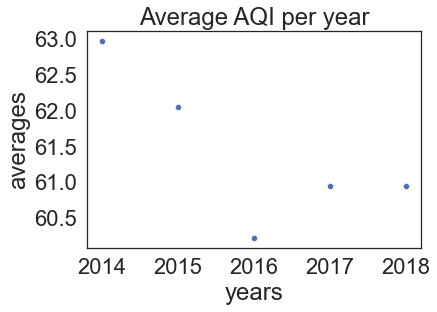

In [19]:
#average AQI per year 
chart4 = sns.scatterplot(x = "years", y = "averages", data = df)
chart4.set_title('Average AQI per year')
sns.set(font_scale=1, style="white")

The scatter plot suggests that the average AQI across the Central Valley has decreased from 2014-2018.

We then calculated the average AQI for each year (2014-2018) for each county to explore the correlation between avg. AQI and deaths by resp. disease.

In [8]:
#get average AQI for each year for each county and append those values to the respiratory deaths data frame 
counties = ['Butte', 'Fresno', 'Glenn', 'Kern', 'Kings', 'Madera', 
            'Merced', 'Placer', 'San Joaquin', 'Sacramento', 'Shasta', 'Solano', 'Stanislaus', 'Sutter', 'Tehama', 'Tulare']

years = [aqi_2014, aqi_2015, aqi_2016, aqi_2017, aqi_2018]
ans = []

for county in counties:
    for year in years:
        currCounty = year[(year['county Name'] == county)]
        currAve = currCounty[["AQI"]].mean()
        ans.append(currAve[0])


deaths_by_respiratory_per_county_pop['County AQI'] = ans

We created a scatterplot for every year from 2014 to 2018. The scatterplot for each year would compare the average the count of deaths by respiratory disease per county by the county's aqi score. We used hue to specify each dot as a county. 

In [9]:
aqi_vs_death = pd.DataFrame()
tmp = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop['Year']==2014]["Count"].tolist()
tmp1 = cancer_sub["Population"].tolist()
tmp2 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop["Year"] == 2014]["County AQI"].tolist()
tmp3 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop["Year"] == 2014]["County"].tolist()
aqi_vs_death["population"] = tmp1
aqi_vs_death["deaths_for_2014"] = tmp
aqi_vs_death["AQI_for_2014"] = tmp2
aqi_vs_death["County"] = tmp3
aqi_vs_death["ratio_for_2014"] = aqi_vs_death["deaths_for_2014"] / aqi_vs_death["population"]

death2015 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop['Year']==2015]["Count"].tolist()
aqi2015 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop["Year"] == 2015]["County AQI"].tolist()
aqi_vs_death["deaths_for_2015"] = death2015
aqi_vs_death["AQI_for_2015"] = aqi2015
aqi_vs_death["ratio_for_2015"] = aqi_vs_death["deaths_for_2015"] / aqi_vs_death["population"]

death2016 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop['Year']==2016]["Count"].tolist()
aqi2016 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop["Year"] == 2016]["County AQI"].tolist()
aqi_vs_death["deaths_for_2016"] = death2016
aqi_vs_death["AQI_for_2016"] = aqi2016
aqi_vs_death["ratio_for_2016"] = aqi_vs_death["deaths_for_2016"] / aqi_vs_death["population"]

death2017 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop['Year']==2017]["Count"].tolist()
aqi2017 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop["Year"] == 2017]["County AQI"].tolist()
aqi_vs_death["deaths_for_2017"] = death2017
aqi_vs_death["AQI_for_2017"] = aqi2017
aqi_vs_death["ratio_for_2017"] = aqi_vs_death["deaths_for_2017"] / aqi_vs_death["population"]

death2018 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop['Year']==2018]["Count"].tolist()
aqi2018 = deaths_by_respiratory_per_county_pop.loc[deaths_by_respiratory_per_county_pop["Year"] == 2018]["County AQI"].tolist()
aqi_vs_death["deaths_for_2018"] = death2018
aqi_vs_death["AQI_for_2018"] = aqi2018
aqi_vs_death["ratio_for_2018"] = aqi_vs_death["deaths_for_2018"] / aqi_vs_death["population"]

We used a scatter plot to graph the average AQI of each county against the county's ratio of deaths by resp. disease to population in 2014.

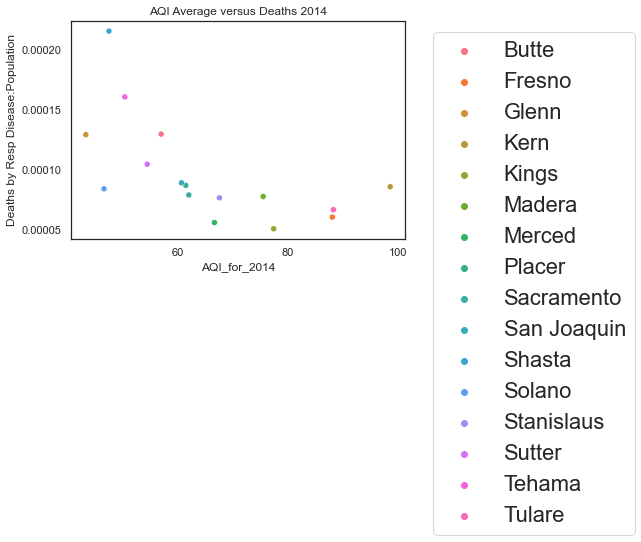

In [10]:
chart2014 = sns.scatterplot(x = "AQI_for_2014", y = "ratio_for_2014", hue = "County", data = aqi_vs_death)
chart2014.set_title('AQI Average versus Deaths 2014')

sns.set(font_scale=2, style="white")
chart2014.set_ylabel('Deaths by Resp Disease:Population')
plt.legend(bbox_to_anchor=(1.05, 1))

We then ran a linear regression analysis and t-test via OLS. 

In [11]:
outcome, predictors = patsy.dmatrices('AQI_for_2014 ~ deaths_for_2014', aqi_vs_death)
mod = sm.OLS(outcome, predictors)
res_2 = mod.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:           AQI_for_2014   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.161
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.300
Time:                        09:41:40   Log-Likelihood:                -66.278
No. Observations:                  16   AIC:                             136.6
Df Residuals:                      14   BIC:                             138.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          59.9047      6.462     

The regression shows an r-squared of 0.077, which is a very weak regression. The p-value of 0.300 suggests there is no significant effect of avg AQI on death rate by resp. disease in 2017. 

We used a scatter plot to graph the average AQI of each county against the county's ratio of deaths by resp. disease to population in 2015.

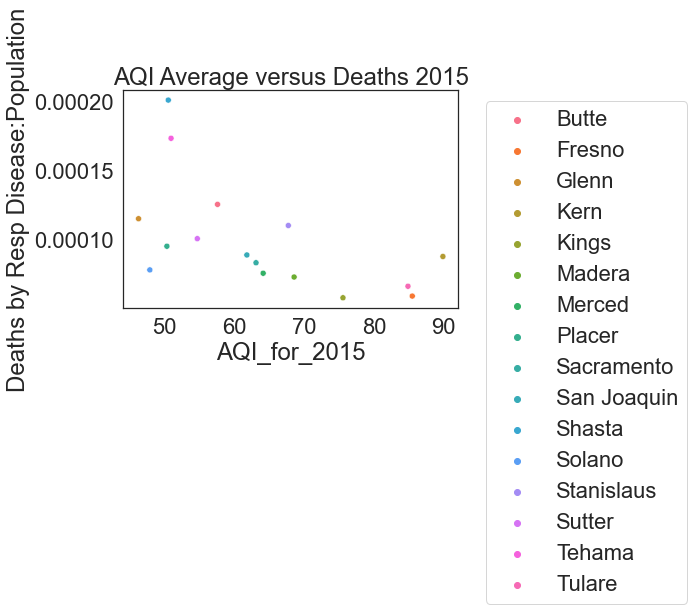

In [12]:
chart2015 = sns.scatterplot(x = "AQI_for_2015", y = "ratio_for_2015", hue = "County", data = aqi_vs_death)
chart2015.set_title('AQI Average versus Deaths 2015')

sns.set(font_scale=2, style="white")
chart2015.set_ylabel('Deaths by Resp Disease:Population')
plt.legend(bbox_to_anchor=(1.05, 1))

We then ran a linear regression analysis and t-test via OLS. 

In [13]:
outcome, predictors = patsy.dmatrices('AQI_for_2015 ~ deaths_for_2015', aqi_vs_death)
mod = sm.OLS(outcome, predictors)
res_3 = mod.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:           AQI_for_2015   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.566
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.231
Time:                        09:41:41   Log-Likelihood:                -63.681
No. Observations:                  16   AIC:                             131.4
Df Residuals:                      14   BIC:                             132.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          58.3593      5.487     

The regression shows an r-squared of 0.101, which is a very weak regression. The p-value of 0.231 suggests there is no significant effect of avg AQI on death rate by resp. disease in 2015. 

We used a scatter plot to graph the average AQI of each county against the county's ratio of deaths by resp. disease to population in 2016.

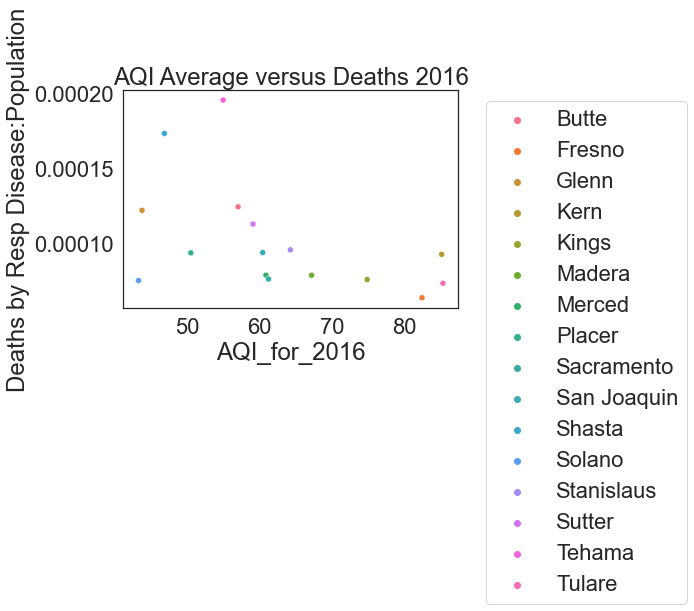

In [14]:
chart2016 = sns.scatterplot(x = "AQI_for_2016", y = "ratio_for_2016", hue = "County", data = aqi_vs_death)
chart2016.set_title('AQI Average versus Deaths 2016')

sns.set(font_scale=2, style="white")
chart2016.set_ylabel('Deaths by Resp Disease:Population')
plt.legend(bbox_to_anchor=(1.05, 1))

We then ran a linear regression analysis and t-test via OLS. 

In [15]:
outcome, predictors = patsy.dmatrices('AQI_for_2016 ~ deaths_for_2016', aqi_vs_death)
mod = sm.OLS(outcome, predictors)
res_4 = mod.fit()
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:           AQI_for_2016   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.650
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.220
Time:                        09:41:41   Log-Likelihood:                -63.217
No. Observations:                  16   AIC:                             130.4
Df Residuals:                      14   BIC:                             132.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          56.7087      5.495     

The regression shows an r-squared of 0.105, which is a very weak regression. The p-value of 0.220 suggests there is no significant effect of avg AQI on death rate by resp. disease in 2016. 

We used a scatter plot to graph the average AQI of each county against the county's ratio of deaths by resp. disease to population in 2017.

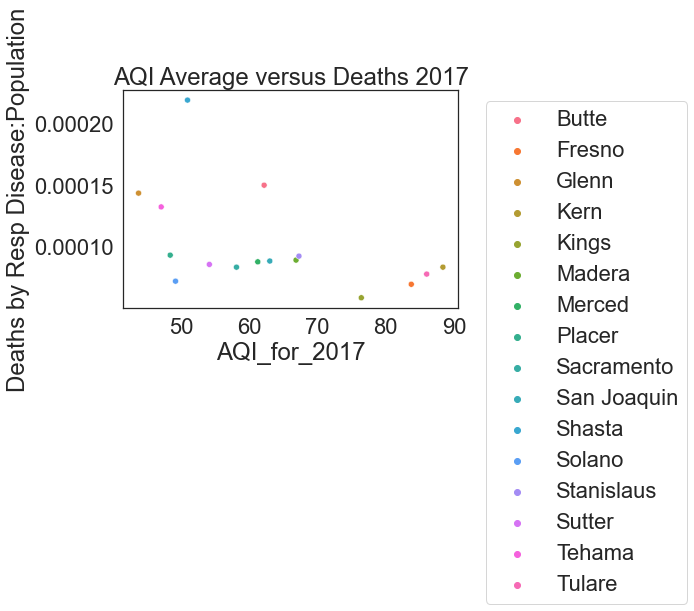

In [18]:
chart2017 = sns.scatterplot(x = "AQI_for_2017", y = "ratio_for_2017", hue = "County", data = aqi_vs_death)
chart2017.set_title('AQI Average versus Deaths 2017')

sns.set(font_scale=2, style="white")
chart2017.set_ylabel('Deaths by Resp Disease:Population')
plt.legend(bbox_to_anchor=(1.05, 1))

We then ran a linear regression analysis and t-test via OLS. 

In [ ]:
outcome, predictors = patsy.dmatrices('AQI_for_2017 ~ deaths_for_2017', aqi_vs_death)
mod = sm.OLS(outcome, predictors)
res_5 = mod.fit()
print(res_5.summary())

                            OLS Regression Results                            
Dep. Variable:           AQI_for_2017   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.493
Date:                Sun, 05 Jun 2022   Prob (F-statistic):              0.242
Time:                        21:38:52   Log-Likelihood:                -64.002
No. Observations:                  16   AIC:                             132.0
Df Residuals:                      14   BIC:                             133.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          57.4841      5.679     

The regression shows an r-squared of 0.096, which is a very weak regression. The p-value of 0.242 suggests there is no significant effect of avg AQI on death rate by resp. disease in 2017. 

We used a scatter plot to graph the average AQI of each county against the county's ratio of deaths by resp. disease to population in 2018.

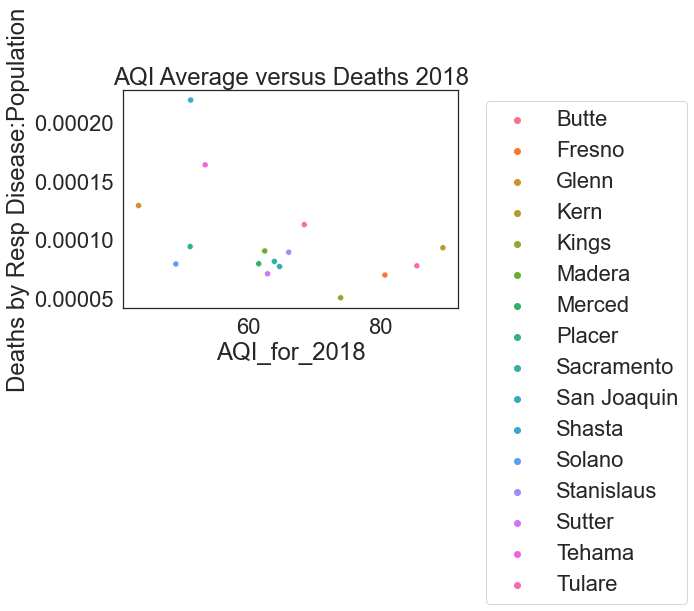

In [ ]:
chart2018 = sns.scatterplot(x = "AQI_for_2018", y = "ratio_for_2018", hue = "County", data = aqi_vs_death)
chart2018.set_title('AQI Average versus Deaths 2018')

sns.set(font_scale=2, style="white")
chart2018.set_ylabel('Deaths by Resp Disease:Population')
plt.legend(bbox_to_anchor=(1.05, 1))

We then ran a linear regression analysis and t-test via OLS. 

In [ ]:
outcome, predictors = patsy.dmatrices('AQI_for_2018 ~ deaths_for_2018', aqi_vs_death)
mod = sm.OLS(outcome, predictors)
res_6 = mod.fit()
print(res_6.summary())

                            OLS Regression Results                            
Dep. Variable:           AQI_for_2018   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2.394
Date:                Sun, 05 Jun 2022   Prob (F-statistic):              0.144
Time:                        21:38:53   Log-Likelihood:                -62.285
No. Observations:                  16   AIC:                             128.6
Df Residuals:                      14   BIC:                             130.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          58.1654      5.038     

The regression shows an r-squared of 0.146, which is a very weak regression. The p-value of 0.144 suggests there is no significant effect of avg AQI on death rate by resp. disease in 2018. 